In [1]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.evaluation.summary import full_evaluation

In [2]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.evaluation.summary import full_evaluation

In [3]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
torch.cuda.set_device(0)
if (config.device == "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)    
else:
    config.update({"device": "cpu"}, allow_val_change=True)

set_seed(1)

### Data Preprocess

In [4]:
def rolling_window(data, window_size):
    n_windows = data.shape[0] - window_size + 1
    windows = np.zeros((n_windows, window_size, data.shape[1]))
    for idx in range(n_windows):
        windows[idx] = data[idx:idx + window_size]
    return windows

# Step 1: Load and preprocess data
df = pd.read_csv("./data/indices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric).astype(float)
#df.drop(columns='Hang Seng', inplace=True)


# Step 2: Compute log 4
log_returns = np.diff(np.log(df), axis=0)
print(log_returns.shape)

# Step 3: Scale the log returns
log_returns_scaled, scalers = scaling(log_returns)

# Step 4: Prepare initial prices and create rolling windows
init_price = torch.from_numpy(np.array(df)[:-(config.n_steps), :]).float().unsqueeze(1)
log_returns_scaled = torch.from_numpy(rolling_window(log_returns_scaled, config.n_steps)).float()
log_returns_org = torch.from_numpy(rolling_window(log_returns, config.n_steps)).float()
print('log_returns_scaled:', log_returns_scaled.shape)

(6189, 6)
log_returns_scaled: torch.Size([5934, 256, 6])


### Log Return Path

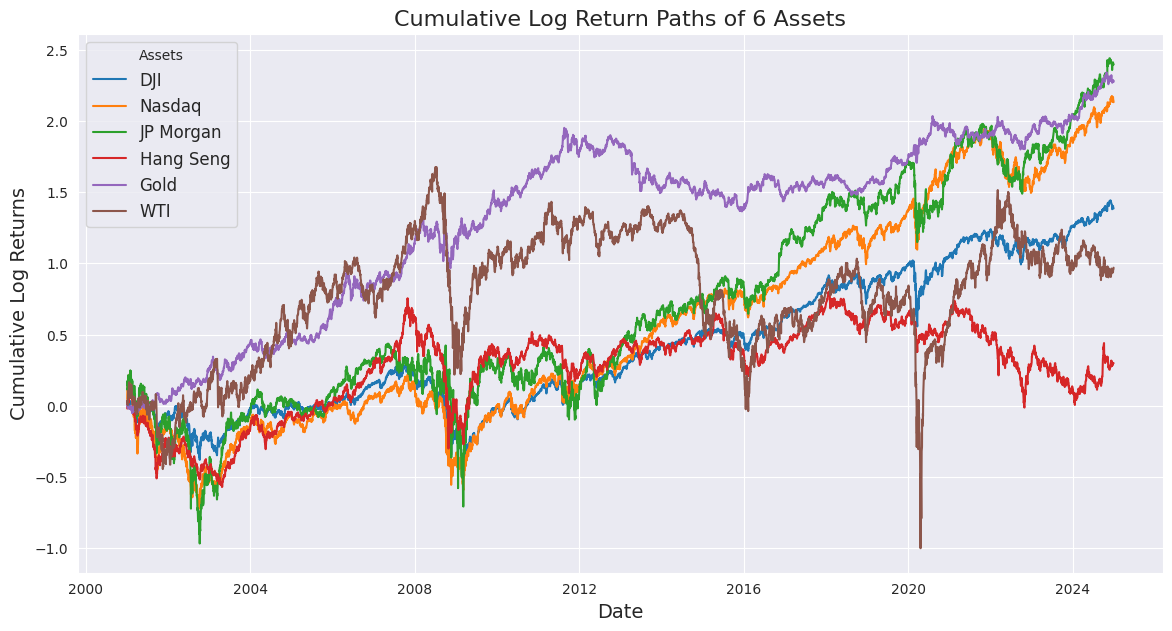

In [5]:
# Step 3: Compute cumulative log returns
cumulative_log_returns = np.cumsum(log_returns, axis=0)

# Step 4: Create a DataFrame for cumulative log returns
cumulative_log_returns_df = pd.DataFrame(
    cumulative_log_returns,
    index=df.index[1:],  # Adjust index for cumulative log returns
    columns=df.columns
)

# Step 5: Plot the cumulative log return paths
plt.figure(figsize=(14, 7))
for col in cumulative_log_returns_df.columns:
    plt.plot(cumulative_log_returns_df.index, cumulative_log_returns_df[col], label=col)

plt.title("Cumulative Log Return Paths of 6 Assets", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Log Returns", fontsize=14)
plt.legend(title="Assets", fontsize=12)
plt.grid(True)
plt.show()


### Generative models for time series generation

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [6]:
train_size = int(log_returns_scaled.shape[0] * 0.7)

training_data = log_returns_scaled[:train_size]
test_data = log_returns_scaled[train_size:]

train_init_price = init_price[:train_size]

training_data_org = log_returns_org[:train_size]
test_data_org = log_returns_org[train_size:]

print("training_data: ", training_data.shape)
print("test_data: ", test_data.shape)

training_data:  torch.Size([4153, 256, 6])
test_data:  torch.Size([1781, 256, 6])


Load the dataset


In [7]:
training_set = TensorDataset(training_data)
test_set = TensorDataset(test_data)

train_dl = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=config.batch_size, shuffle=True)

### Generative model

### Initialize the generator, discriminator and the trainer

In [8]:
from src.baselines.networks.discriminators import TCNDiscriminator
from src.baselines.networks.generators import TCNGenerator
from src.baselines.trainer import *

generators = {}
discriminators = {}

for i in range(config.n_vars):
    generators[i] = TCNGenerator(config).to(config.device)
    discriminators[i] = TCNDiscriminator(config).to(config.device)
trainer = GANTrainer(G=generators, D=discriminators, train_dl=train_dl, config=config)

### Model training and saving

In [9]:
# # Model training
#trainer.fit()

# Model Evaluation

### MVFIT-GAN

In [10]:
from scipy.stats import entropy, wasserstein_distance, ks_2samp, spearmanr, kendalltau
from statsmodels.tsa.stattools import acf
from scipy.spatial.distance import jensenshannon

full_name = "_1_300_256_Glr_0.0002_Dlr_0.0001_hidden_dim_64_n_steps_256_corr_loss_l1_corr_weight_0.05_f_epoch_40_n_critic_2_gp_10.0_noise_4_Adam_drop_0.0_0.2_8_splitupdate_v2_corrlinear_overall_Adam0.5_withoutCorr"

In [11]:
""" Find the best epochs based on 100 days cumulative distribution """

from src.baselines.networks.generators import TCNGenerator
#gen_tmp = Generator(config)
min_dist = float('inf')  
best_epoch = 0

# rolling window 크기 (예: 100 days)
window = 100

def compute_avg_emd(real_data, fake_data, window):
    """
    real_data, fake_data: 각각 shape (batch, 1, time)
    각 창(window)마다의 합계를 구하고, 두 분포 간의 Earth Mover's Distance (EMD)를 구하여 합산합니다.
    """
    emd = 0
    # real_data.shape[1]가 1이더라도, loop로 general하게 처리 (만약 다중 feature인 경우 대비)
    for i in range(real_data.shape[1]):
        real_dist = rolling_window(real_data[:, i, :].T, window).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_data[:, i, :].T, window).sum(axis=1).ravel()
        emd += wasserstein_distance(real_dist, fake_dist)
    return emd

def load_sub_generator(file_path, config):
    """
    TCNGenerator를 이용해 저장된 모델을 불러오고, device에 올린 후 eval 모드로 전환합니다.
    """
    sub_gen = TCNGenerator(config)
    sub_gen.load_state_dict(torch.load(file_path, map_location=config.device))
    return sub_gen.to(config.device).eval()

# 검사할 에폭 범위 (예: 70부터 90까지 2 에폭 간격으로 평가)
epochs_to_check = range(120, 180, 2)

# 각 서브 생성자별 최소 EMD와 베스트 에폭 초기화
min_emd = [float('inf')] * config.n_vars
best_epoch = [None] * config.n_vars

# 실제 데이터 로딩: training_data_org는 (batch, time, n_vars) 형태라고 가정하며,
real_data = training_data_org.transpose(1, 2).cpu().numpy()


# Generator 평가에 사용할 노이즈 생성 (예시: 3000 샘플)
noise = torch.randn(3000, config.noise_dim, config.n_steps).to(config.device)

# 각 에폭마다 각 서브 생성자(변수별)를 평가
for epoch in epochs_to_check:
    for i in range(config.n_vars):
        # 저장된 모델의 경로 구성 (예전에 저장했던 경로와 파일명이 일치해야 합니다.)
        file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{epoch}_var_{i}.pt")
        # 파일이 존재하지 않으면 continue
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        # 서브 생성자 로딩
        sub_gen = load_sub_generator(file_path, config)        
        with torch.no_grad():
            fake = sub_gen(noise)  # fake의 shape는 (batch, 1, time) 이어야 합니다.
        
        # inverse_scaling_split 함수로 후처리 (scalers 및 변수 i에 맞게 진행)
        fake_data = inverse_scaling_split(fake, scalers, i)  # scalers가 미리 정의되어 있어야 합니다.
        
        # 실제 데이터와 fake 데이터의 EMD 계산 (각 변수별로)
        emd_val = compute_avg_emd(real_data[:, i:i+1, :], fake_data, window)
        if emd_val < min_emd[i]:
            min_emd[i] = emd_val
            best_epoch[i] = epoch
    
    print(f"Epoch {epoch}: best_epoch = {best_epoch}, min_emd = {min_emd}")

print("\n--- 최종 결과: 각 서브 생성자별 Best Epoch ---")
for i in range(config.n_vars):
    print(f"SubGen {i}: best epoch = {best_epoch[i]}, EMD = {min_emd[i]:.3f}")

Epoch 120: best_epoch = [120, 120, 120, 120, 120, 120], min_emd = [0.022227588827107174, 0.01978226748558164, 0.03188747668301497, 0.023635791753658916, 0.00596642105961163, 0.07960660318368559]
Epoch 122: best_epoch = [122, 120, 120, 122, 122, 122], min_emd = [0.009947228348029222, 0.01978226748558164, 0.03188747668301497, 0.009048513697726397, 0.0055374128210351715, 0.039771676602868254]
Epoch 124: best_epoch = [122, 120, 120, 122, 122, 124], min_emd = [0.009947228348029222, 0.01978226748558164, 0.03188747668301497, 0.009048513697726397, 0.0055374128210351715, 0.026302448167435814]
Epoch 126: best_epoch = [122, 120, 120, 122, 122, 126], min_emd = [0.009947228348029222, 0.01978226748558164, 0.03188747668301497, 0.009048513697726397, 0.0055374128210351715, 0.019324798012799956]
Epoch 128: best_epoch = [122, 120, 120, 122, 122, 126], min_emd = [0.009947228348029222, 0.01978226748558164, 0.03188747668301497, 0.009048513697726397, 0.0055374128210351715, 0.019324798012799956]
Epoch 130: be

In [12]:
real_data = test_data_org.transpose(1, 2).cpu().numpy()

fake_series_list = []
for i in range(config.n_vars):    
    best_ep = best_epoch[i]  # 각 서브 생성자의 가장 좋은 에폭  
    file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{best_ep}_var_{i}.pt")
    
    # 서브 생성자 로딩: 수정된 load_sub_generator 함수 호출 (TCNGenerator 파라미터 제거)
    sub_gen = load_sub_generator(file_path, config)
    
    with torch.no_grad():
        # fake의 shape: (batch, 1, n_steps)
        fake = sub_gen(noise)
    
    # scalers[i]를 적용하여 inverse scaling 진행 (출력이 (batch, 1, n_steps) 형태임)
    fake_data_i = inverse_scaling_split(fake, scalers, i)
    # 필요 시 numpy array를 torch.Tensor로 변환 (device 및 dtype 맞춤)
    fake_data_i = torch.tensor(fake_data_i, device=config.device)
    
    fake_series_list.append(fake_data_i)

# 변수 축(dim=1)을 따라 결합: 최종 다변량 시계열의 shape는 (batch, n_vars, n_steps)
fake_data = torch.cat(fake_series_list, dim=1)
fake_data = fake_data.cpu().numpy()
print("다변량 시계열 데이터의 shape:", fake_data.shape)

np.save('fake_data.npy', fake_data)

다변량 시계열 데이터의 shape: (3000, 6, 256)


In [13]:
""" Fake data와 Test data를 비교 """
for idx in range(6):
    # 각 feature의 전체 최소값 및 최대값 계산
    min_vals = np.expand_dims(real_data[:, idx, :], axis=1).min(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)
    max_vals = np.expand_dims(real_data[:, idx, :], axis=1).max(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)

    # 마스크 계산 (모든 샘플이 범위 내에 있는지 확인)
    mask_0 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.0) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.0), axis=(1, 2))
    mask_25 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.25) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.25), axis=(1, 2))
    mask_50 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.50) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.50), axis=(1, 2))
    mask_100 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 2.0) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 2.0), axis=(1, 2))

    # 마스크를 적용하여 fake_data 필터링
    print(fake_data.shape, type(fake_data))

    fake_data_0 = fake_data[mask_0]
    fake_data_25 = fake_data[mask_25]
    fake_data_50 = fake_data[mask_50]
    fake_data_100 = fake_data[mask_100]
    #fake_data = fake_data_50
    print(fake_data_0.shape)
    print(fake_data_25.shape)
    print(fake_data_50.shape)
    print(fake_data_100.shape)
    print()
    fake_data_tmp = fake_data[:3000]

    print(real_data.shape)
    print(f"Filtered shape: {fake_data.shape}")

(3000, 6, 256) <class 'numpy.ndarray'>
(2965, 6, 256)
(2998, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2878, 6, 256)
(2963, 6, 256)
(2993, 6, 256)
(3000, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2475, 6, 256)
(2678, 6, 256)
(2792, 6, 256)
(2934, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2661, 6, 256)
(2984, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(1781, 6, 256)
Filtered shape: (3000, 6, 256)


In [14]:
""" Visualize the distribution of the real and fake data """
fake_list = [fake_data[:, i, :] for i in range(fake_data.shape[1])]
real_list = [real_data[:, i, :] for i in range(real_data.shape[1])]

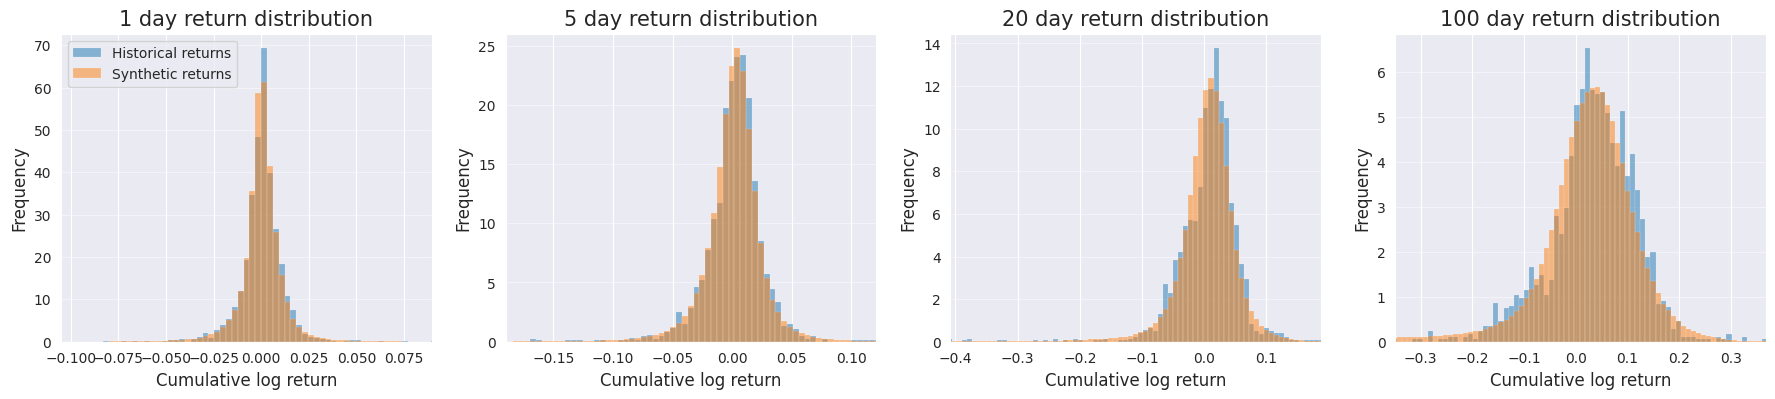

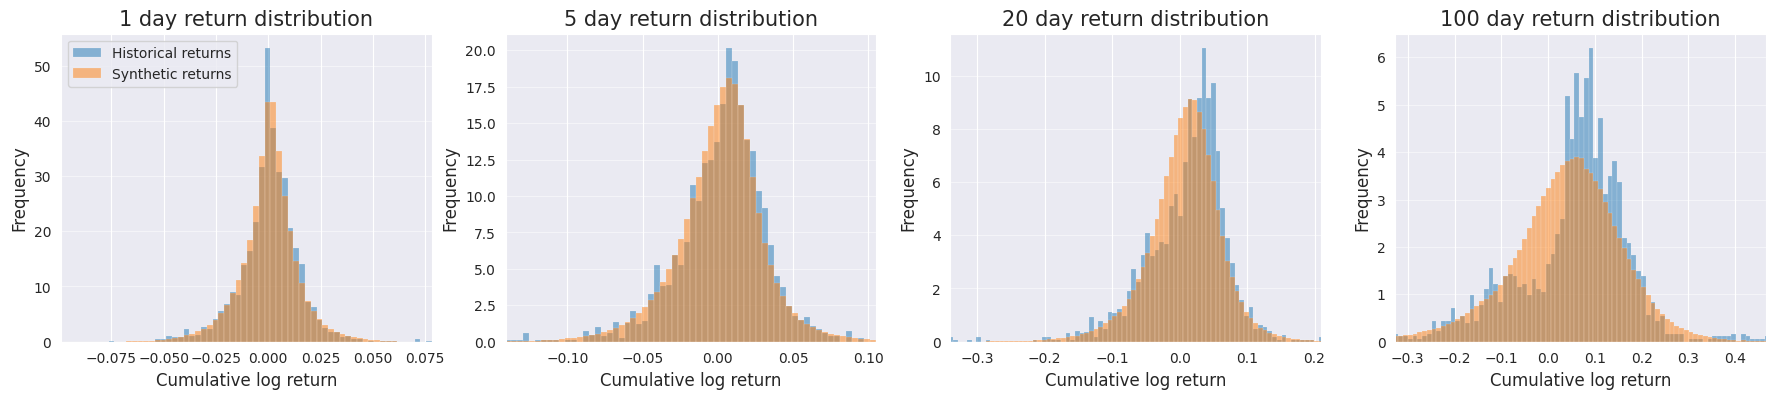

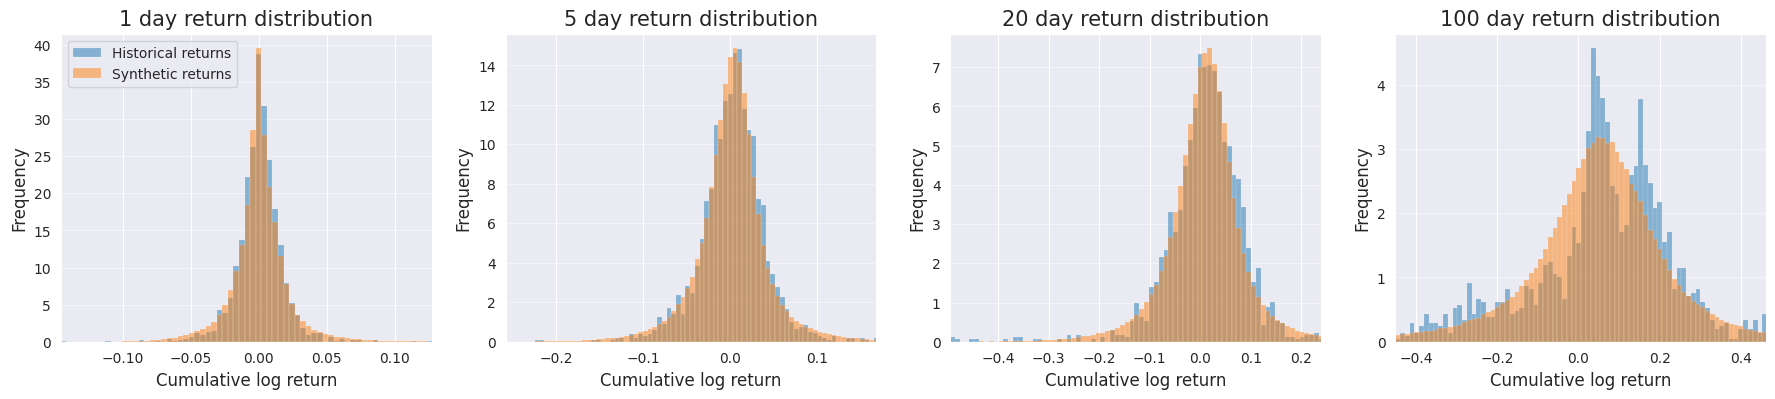

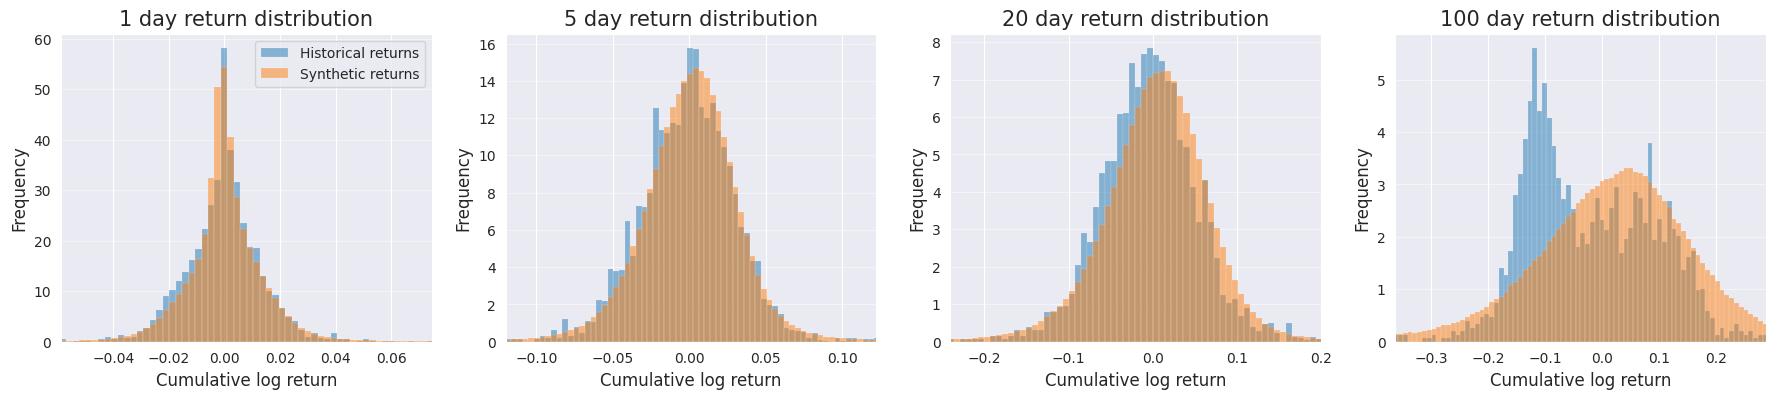

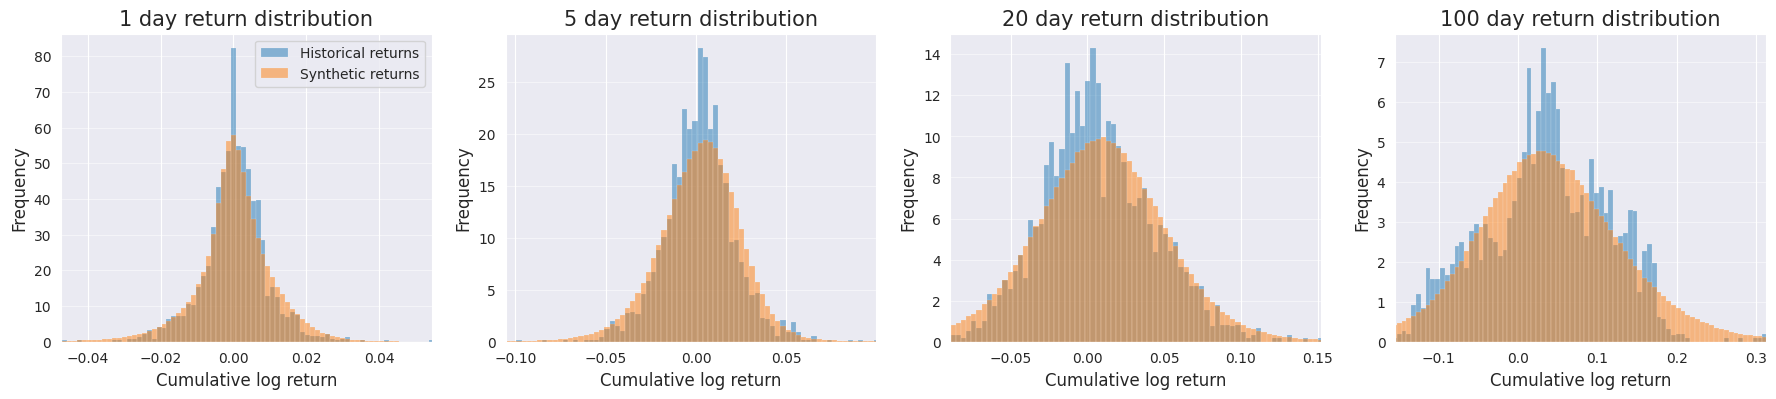

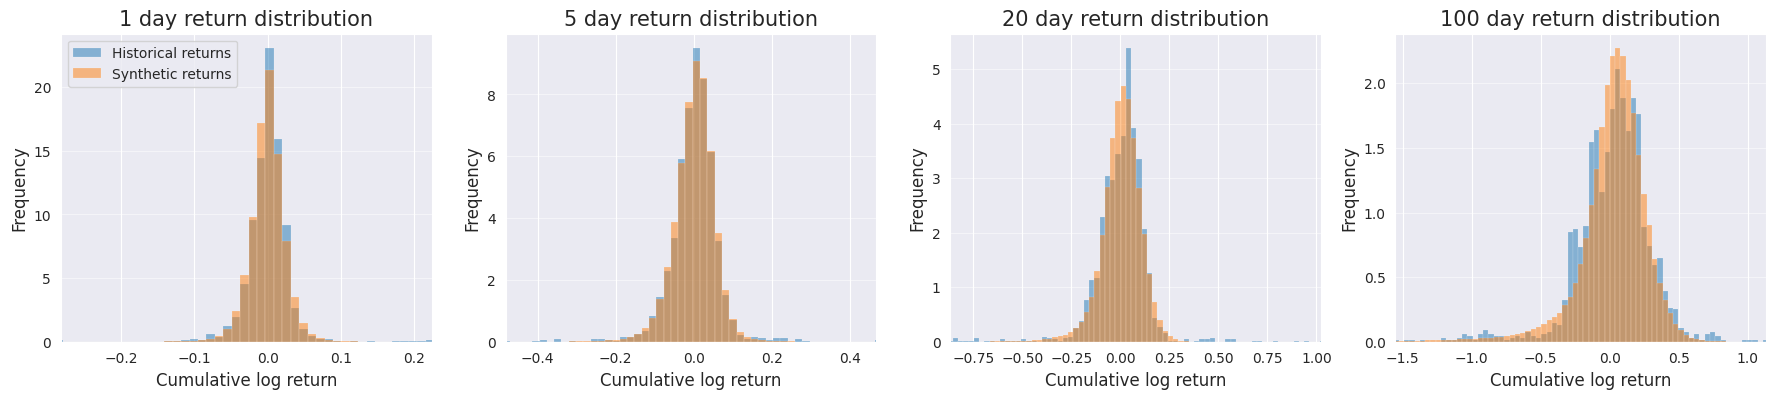

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4   EMD 5  EMD_avg
 window size                                                         
 1            0.0005  0.0007  0.0022  0.0010  0.0012  0.0025   0.0013
 5            0.0013  0.0019  0.0033  0.0028  0.0030  0.0044   0.0028
 20           0.0041  0.0070  0.0083  0.0106  0.0068  0.0139   0.0084
 100          0.0178  0.0214  0.0238  0.0566  0.0121  0.0264   0.0264,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4    KL 5
 window size                                                
 1            0.0303  0.0497  0.0474  0.0432  0.0503  0.1067
 5            0.0281  0.0379  0.0314  0.0257  0.0632  0.0487
 20           0.0506  0.0689  0.0549  0.0463  0.0528  0.1604
 100          0.0517  0.1082  0.0807  0.2065  0.0899  0.1007,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4    JS 5
 window size                                                
 1            0.0877  0.0795  0.1055  0.1082  0.1152  0.0750
 5        

In [15]:
# Plot the distribution of the real and fake data
windows = [1, 5, 20, 100]
for j in range(config.n_vars):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(22, 4))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real_list[j].T, windows[i]).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=1).ravel()        
        
        min_val = real_dist.min()
        max_val = real_dist.max()
        
        bins = np.linspace(min_val, max_val, 81)  
        
        sns.histplot(real_dist, bins=bins, kde=False, ax=axs[col], color='tab:blue', linewidth=0.1, alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=False, ax=axs[col], color='tab:orange', linewidth=0.1, alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=15)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])    
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.savefig(f"figure_dist{j}.png", dpi=300, bbox_inches='tight')
plt.show()

def calculate_distribution_scores(real, fake, num_G, windows):
    scores = {
        'EMD': np.zeros((num_G, len(windows))),
        'KL': np.zeros((num_G, len(windows))),
        'JS': np.zeros((num_G, len(windows))),
        'KS': np.zeros((num_G, len(windows)))
    }

    for i in range(num_G):
        for j in range(len(windows)):
            real_dist = rolling_window(real[i].T, windows[j]).sum(axis=1).ravel()
            fake_dist = rolling_window(fake[i].T, windows[j]).sum(axis=1).ravel()
            
            np.random.shuffle(real_dist)
            np.random.shuffle(fake_dist)
            
            # Calculate EMD
            scores['EMD'][i, j] = wasserstein_distance(real_dist, fake_dist)
            
            # Calculate KS Statistic
            scores['KS'][i, j], _ = ks_2samp(real_dist, fake_dist)                                    
            
            # Create histograms to estimate the probability distributions
            real_hist, bin_edges = np.histogram(real_dist, bins=100, density=True)
            fake_hist, _ = np.histogram(fake_dist, bins=bin_edges, density=True)
            
            # Normalize the histograms to get probability distributions
            real_prob = real_hist / np.sum(real_hist)
            fake_prob = fake_hist / np.sum(fake_hist)
            
            # Calculate KL Divergence
            kl_divergence = entropy(real_prob + 1e-10, fake_prob + 1e-10)
            scores['KL'][i, j] = kl_divergence

            # Calculate JS Divergence
            js_divergence = jensenshannon(real_prob + 1e-10, fake_prob + 1e-10)
            scores['JS'][i, j] = js_divergence
                
    df_scores = {}
    for metric, data in scores.items():
        data = np.round(data, decimals=4)
        df_scores[metric] = pd.DataFrame(data.T, index=windows, columns=[f'{metric} {i}' for i in range(num_G)])
        
    emd_avg = np.mean(scores['EMD'], axis=0)
    df_scores['EMD']['EMD_avg'] = np.round(emd_avg, decimals=4)
    
    return df_scores

# Calculate the distribution scores
windows = pd.Series([1, 5, 20, 100], name='window size')

results_emd = calculate_distribution_scores(real_list, fake_list, config.n_vars, windows)
results_emd

In [16]:
def correlation_mean(data):
    """
    각 샘플의 상관행렬을 계산한 후, 그 평균을 반환.
    
    Parameters:
        data (np.ndarray): shape = (num_samples, num_time_steps, num_features)
    
    Returns:
        mean_correlation_matrix (np.ndarray): shape = (num_features, num_features)
    """
    num_samples = data.shape[0]
    correlations = []

    for i in range(num_samples):
        sample = data[i]  # shape = (num_time_steps, num_features)
        corr_mat = np.corrcoef(sample, rowvar=False)
        correlations.append(corr_mat)

    mean_correlation_matrix = np.mean(correlations, axis=0)  
    return mean_correlation_matrix


def correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse'):
    """
    Real과 Fake의 평균 상관행렬 간의 손실을 계산.
    
    Parameters:
        real_mean_corr (np.ndarray): Real 데이터의 평균 상관행렬
        fake_mean_corr (np.ndarray): Fake 데이터의 평균 상관행렬
        loss_type (str): 'mse', 'mae', 'frobenius' 중 선택

    Returns:
        loss (float): 지정된 손실 타입에 따른 손실 값 (소수점 4자리로 반올림)
    """
    diff = fake_mean_corr - real_mean_corr

    if loss_type == 'mse':
        loss_val = np.mean(diff**2)
    elif loss_type == 'mae':
        loss_val = np.mean(np.abs(diff))
    elif loss_type == 'frobenius':            
        loss_val = np.linalg.norm(diff, ord='fro')
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")

    return round(loss_val, 4)

# 상관행렬 계산을 위해 데이터 전치 (shape: (num_samples, num_time_steps, num_features))
real_mean_corr = correlation_mean(np.transpose(real_data, (0, 2, 1)))
fake_mean_corr = correlation_mean(np.transpose(fake_data, (0, 2, 1)))

# 손실 계산
loss_mae = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mae')
loss_frob = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='frobenius')
loss_mse = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse')

# 결과 출력
print("[Correlation Loss - MAE]")
print(f"Loss: {loss_mae}")

print("\n[Correlation Loss - Frobenius]")
print(f"Loss: {loss_frob}")

print("\n[Correlation Loss - MSE]")
print(f"Loss: {loss_mse}")


# def plot_correlation_heatmap(correlation_matrix, title, feature_names):
#     fig, ax = plt.subplots(figsize=(5, 4))
#     sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r', linewidths=.5, ax=ax, fmt=".2f", annot_kws={"size": 12}, vmin=-0.1, vmax=1)
    
#     # 축 이름 설정
#     ax.set_xticklabels(feature_names, fontsize=12)
#     ax.set_yticklabels(feature_names, fontsize=12)
    
#     # 제목 및 시각적 요소
#     ax.set_title(title, fontsize=15)
#     ax.tick_params(axis='both', which='major', labelsize=14)
#     plt.tight_layout()
#     plt.show()

# feature_names = ['DJI', 'IXIC', 'JPM', 'HSI', 'Gold', 'WTI']
# plot_correlation_heatmap(real_mean_corr, "Real Data", feature_names)
# plot_correlation_heatmap(fake_mean_corr, "Fake Data", feature_names)


[Correlation Loss - MAE]
Loss: 0.3509

[Correlation Loss - Frobenius]
Loss: 2.6561

[Correlation Loss - MSE]
Loss: 0.196


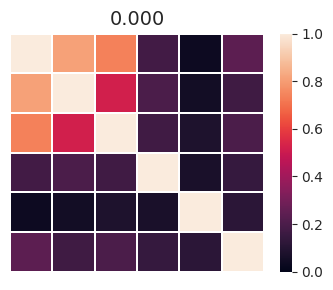

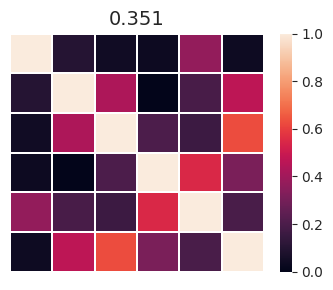

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def plot_correlation_heatmap(corr_mat, loss):
    fig, ax = plt.subplots(figsize=(3.5,3))

    sns.heatmap(
        np.abs(corr_mat),
        cmap='rocket',
        vmin=0, vmax=1,
        linewidths=0.01,
        linecolor="white",
        ax=ax
    )

    # ticks & spines off
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    # loss 숫자만 위쪽에
    ax.text(0.5, 1.02, f"{loss:.3f}",
            ha="center", va="bottom", transform=ax.transAxes,
            fontsize=14)

    plt.tight_layout()
    plt.savefig("fig_corr_real.png", dpi=300, bbox_inches='tight')
    plt.show()


# 예시
real_loss = 0.000
fake_loss = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mae')

plot_correlation_heatmap(real_mean_corr, real_loss)
plot_correlation_heatmap(fake_mean_corr, fake_loss)
